In [103]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


Читаем данные из файла и строим их график

In [104]:
data = pd.read_csv('WAG_C_M.csv',';',index_col=['month'], parse_dates=['month'], dayfirst=True)
data.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


In [105]:
data.shape

(284, 1)

Переименуем столбец с величиной зарплаты для простоты работы с ним

In [106]:
data['wage']=data['WAG_C_M']
del data['WAG_C_M']
data.head()

,wage
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


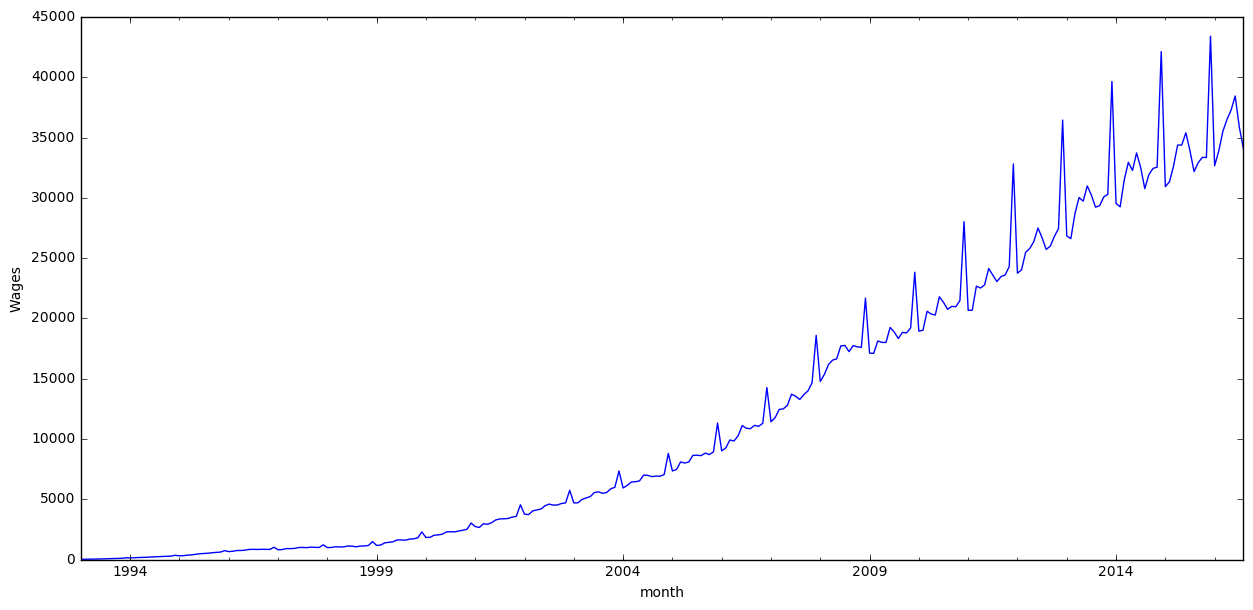

In [107]:
plt.figure(figsize(15,7))
data.wage.plot()
plt.ylabel('Wages')
pylab.show()

На графике зависимости ежемесячной зарплаты от времени видны:
    
        1) Ярко выраженный возрастающий тренд
        2) Сезонность
        3) Возрастающая со временем дисперсия

## Стабилизация дисперсии

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


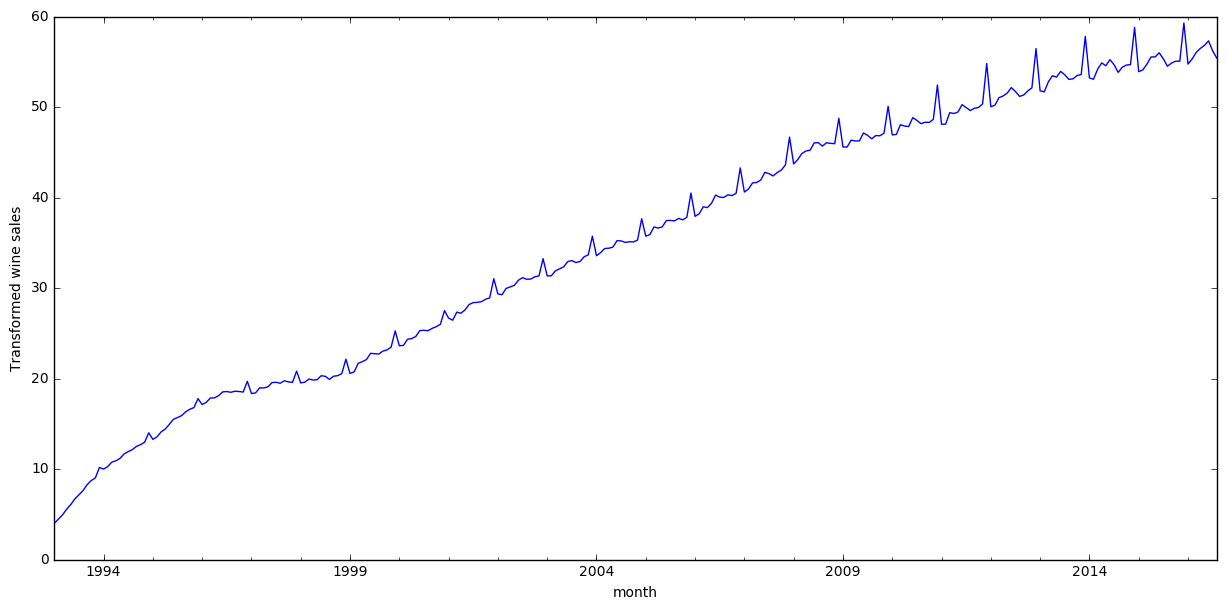

In [108]:
data['wage_box'], lmbda = stats.boxcox(data.wage)
plt.figure(figsize(15,7))
data.wage_box.plot()
plt.ylabel(u'Transformed wine sales')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.wage_box)[1])

Стало чуть лучше.

## Стационарность

Проведем STL-декомпозицию и посмотрим на получившийся результат

Критерий Дики-Фуллера: p=0.696899


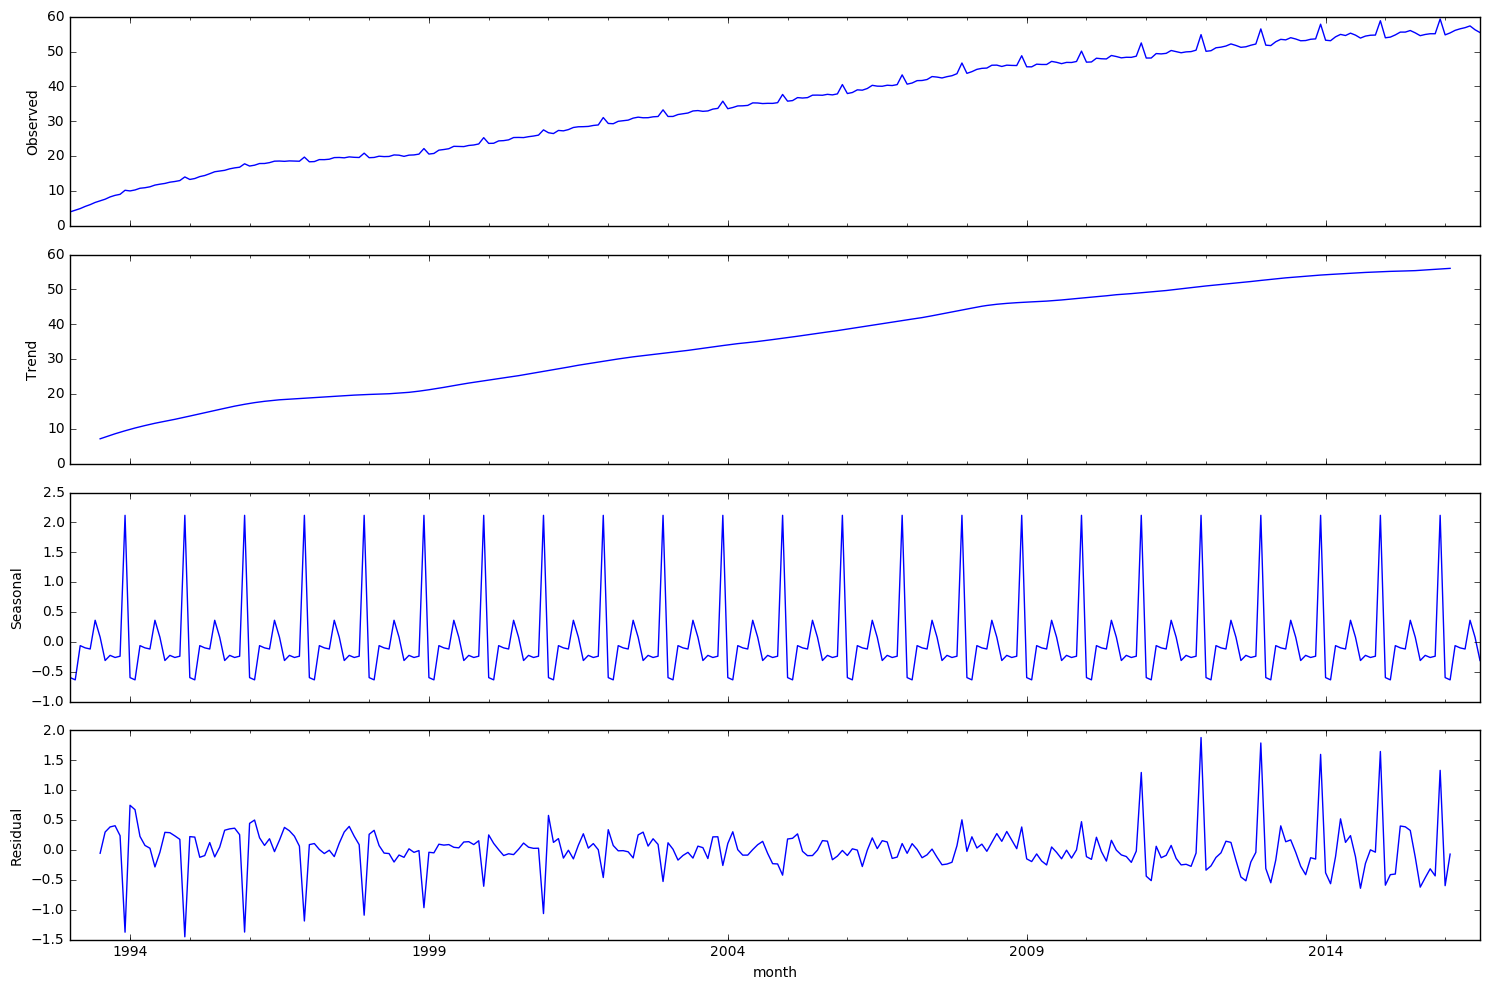

In [109]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.wage_box).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.wage_box)[1])

Величина Критерий Дика-Фуллера получилась высокой: 0.69, следовательно гипотеза о нестационарности нашего временного ряда не отвергается. Впрочем это видно и глазами. В остатках еще есть какая-то информация.

Попробуем сделать сезонное дифференцирование и посмотреть как нам это может помочь.

In [110]:
data['wage_box12']=data.wage_box-data.wage_box.shift(12)
data.head(13)

,wage,wage_box,wage_box12
month,,,
1993-01-01,15.3,3.990393,NaN
1993-02-01,19.1,4.458758,NaN
1993-03-01,23.6,4.931635,NaN
1993-04-01,30.6,5.549430,NaN
1993-05-01,37.5,6.063406,NaN
1993-06-01,47.4,6.690719,NaN
1993-07-01,56.0,7.161310,NaN
1993-08-01,65.4,7.618224,NaN
1993-09-01,80.9,8.275619,NaN


Снова проверим стационарность по критерию Дика-Фуллера:

Критерий Дики-Фуллера: p=0.014697


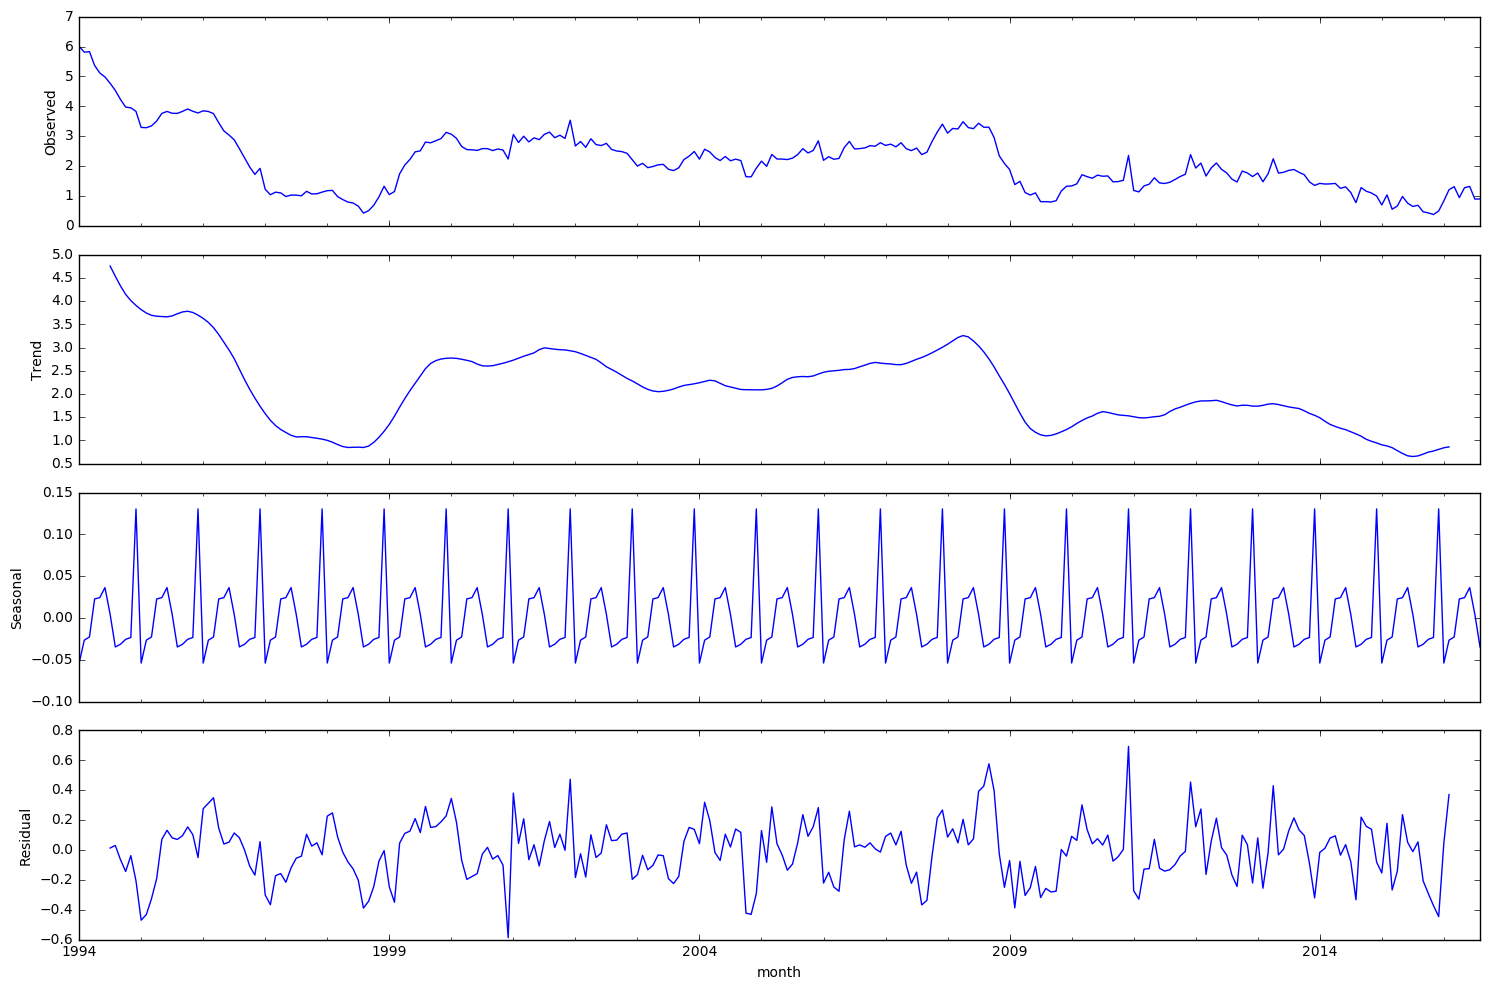

In [111]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.wage_box12[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.wage_box12[12:])[1])

Значение теста ДФ: 0.014, что все еще не позволяет нам отвергнуть гипотезу о нестационарности на уровне значимости 0.01. Продолжим дифференцировать ряд. Применим первые разности к уже сезонно-продифференцированному ряду и посмотрим к чему это приведет.

In [112]:
data['wage_box12_1']=data.wage_box12-data.wage_box12.shift(1)
data.head(14)

,wage,wage_box,wage_box12,wage_box12_1
month,,,,
1993-01-01,15.3,3.990393,NaN,NaN
1993-02-01,19.1,4.458758,NaN,NaN
1993-03-01,23.6,4.931635,NaN,NaN
1993-04-01,30.6,5.549430,NaN,NaN
1993-05-01,37.5,6.063406,NaN,NaN
1993-06-01,47.4,6.690719,NaN,NaN
1993-07-01,56.0,7.161310,NaN,NaN
1993-08-01,65.4,7.618224,NaN,NaN
1993-09-01,80.9,8.275619,NaN,NaN


Критерий Дики-Фуллера: p=0.000000


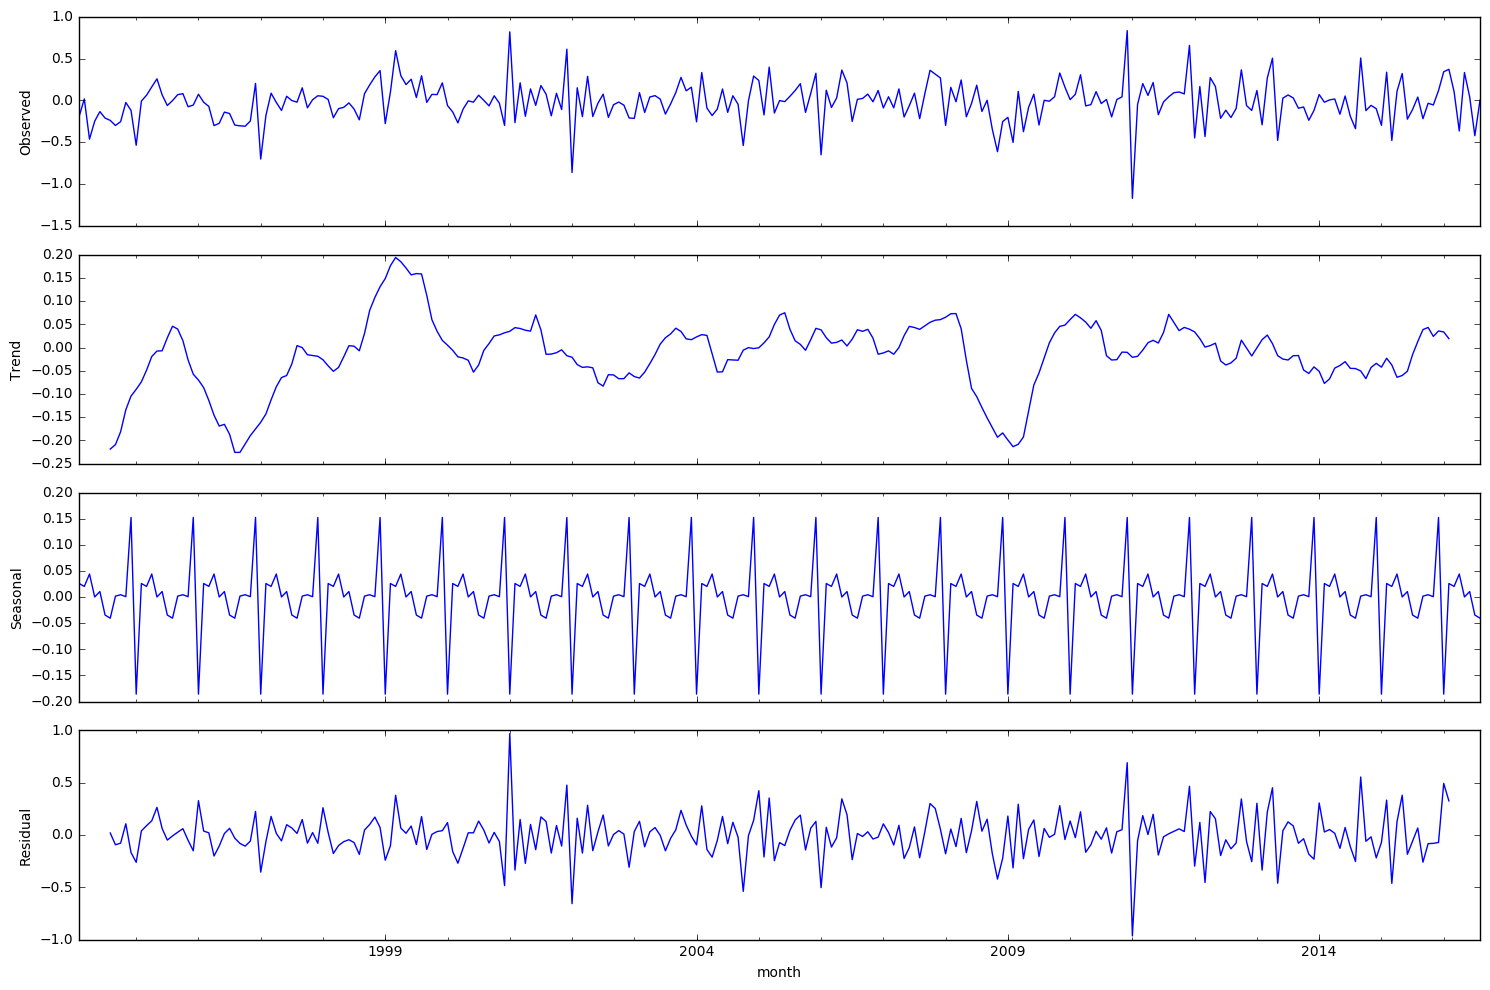

In [113]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.wage_box12_1[13:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.wage_box12_1[13:])[1])

И в этот раз - успех! Гипотеза о нестационарности нашего ряда отвергается после применения сезонного и обычного дифференцирования, а значит мы получили два параметра нашей модели: d=D=1

## Подбор модели

Подберем остальные параметры модели: p, P, q, Q:

Коэффициенты q, Q будем подбирать по графику автокорреляции, p и P - по графику частичной корреляции.

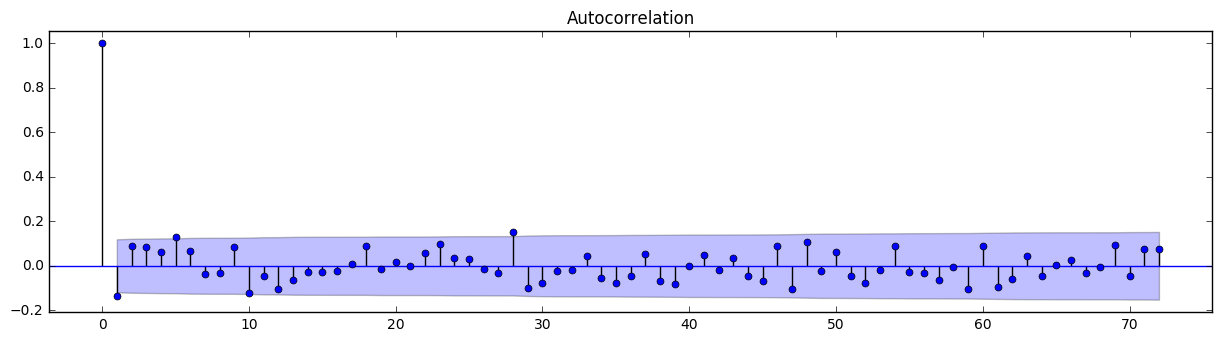

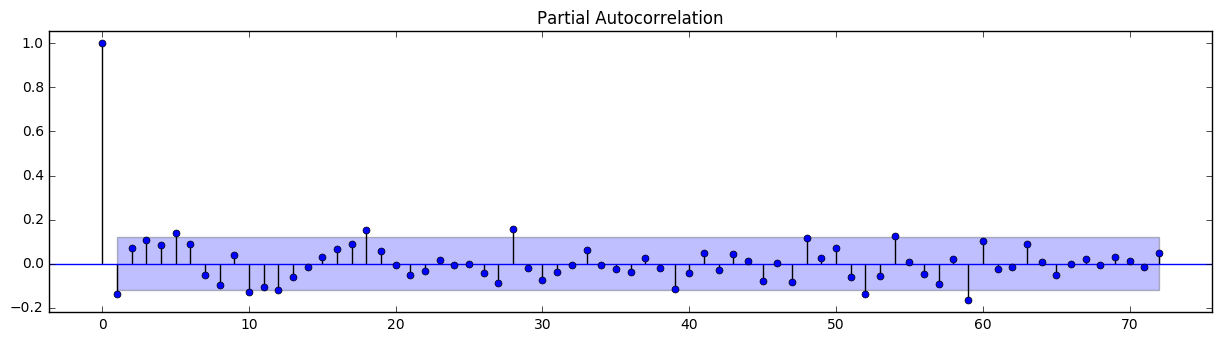

In [114]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.wage_box12_1[13:].values.squeeze(), lags=72, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.wage_box12_1[13:].values.squeeze(), lags=72, ax=ax)
pylab.show()

Выберем следующие начальные значения:
    
    1) q = 5 - последний значимый несезонный лаг на графике автокорреляции
    2) Q = 0 - так как 0 лаг - последний значимый сезонный лаг на графике автокорреляции
    3) p = 10 - последний значимый несезонный лаг на графике частичной автокорреляции (но можно взять и p=5, лучшая подобранная модель от этого не изменится, просто считаться будет примерно раза в два дольше)
    4) P = 4 - так как 48 лаг - последний значимый сезонный лаг на графике частичной автокорреляции

In [115]:
ps = range(0, 11)
d=1
qs = range(0, 6)
Ps = range(0, 5)
D=1
Qs = range(0, 1)

In [116]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

330

In [117]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.wage_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    except LinAlgError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

('wrong parameters:', (0, 0, 0, 0))
('wrong parameters:', (1, 2, 0, 0))
('wrong parameters:', (1, 2, 1, 0))
('wrong parameters:', (1, 2, 2, 0))
('wrong parameters:', (1, 2, 3, 0))
('wrong parameters:', (1, 2, 4, 0))
('wrong parameters:', (2, 1, 0, 0))
('wrong parameters:', (2, 1, 1, 0))
('wrong parameters:', (2, 1, 2, 0))
('wrong parameters:', (2, 1, 3, 0))
('wrong parameters:', (2, 1, 4, 0))
('wrong parameters:', (2, 2, 0, 0))
('wrong parameters:', (2, 2, 1, 0))
('wrong parameters:', (2, 2, 2, 0))
('wrong parameters:', (2, 2, 3, 0))
('wrong parameters:', (2, 2, 4, 0))
('wrong parameters:', (2, 3, 0, 0))
('wrong parameters:', (2, 3, 1, 0))
('wrong parameters:', (2, 3, 2, 0))
('wrong parameters:', (2, 3, 3, 0))
('wrong parameters:', (2, 3, 4, 0))
('wrong parameters:', (3, 2, 0, 0))
('wrong parameters:', (3, 2, 1, 0))
('wrong parameters:', (3, 2, 2, 0))
('wrong parameters:', (3, 2, 3, 0))
('wrong parameters:', (3, 2, 4, 0))
('wrong parameters:', (3, 3, 0, 0))
('wrong parameters:', (3, 3,

In [118]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

       parameters        aic
110  (5, 5, 1, 0) -25.808191
111  (5, 5, 2, 0) -24.697526
130  (6, 5, 1, 0) -23.995658
112  (5, 5, 3, 0) -22.699983
131  (6, 5, 2, 0) -22.625086


Итак, мы подобрали лучшую модель, посмотрим что она из себя представляет:

In [119]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                           wage_box   No. Observations:                  284
Model:             SARIMAX(5, 1, 5)x(1, 1, 0, 12)   Log Likelihood                  24.904
Date:                            Sat, 31 Dec 2016   AIC                            -25.808
Time:                                    18:33:46   BIC                             17.979
Sample:                                01-01-1993   HQIC                            -8.253
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0016      6.975      0.000      1.000     -13.669      13.673
ar.L2          0.0090      4.599   

Посмотрим на остатки:

Критерий Стьюдента: p=0.179810
Критерий Дики-Фуллера: p=0.000000


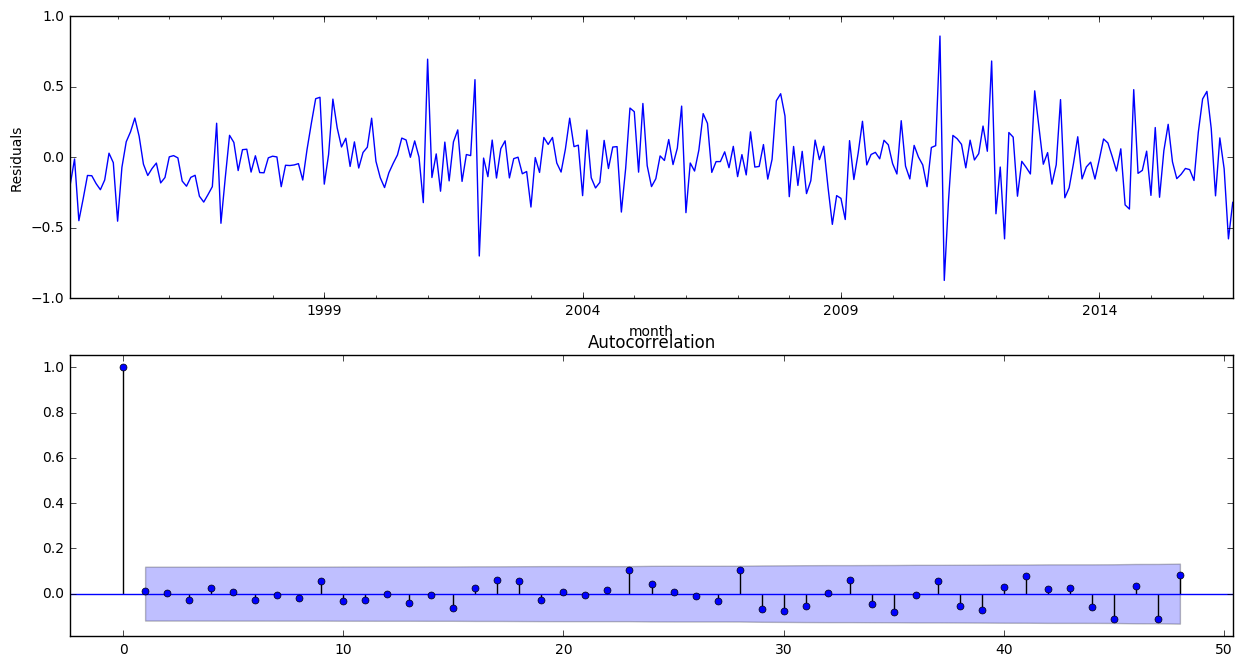

In [120]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).
Посмотрим, насколько хорошо модель описывает данные:

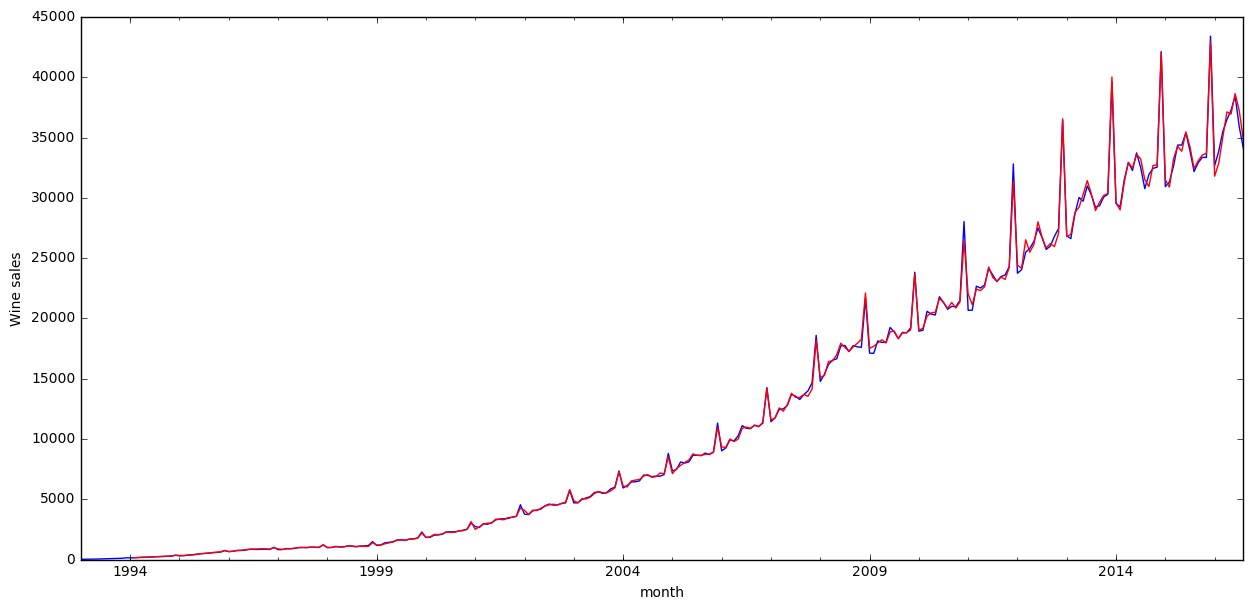

In [121]:
data['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
data.wage.plot()
data.model[13:].plot(color='r')
plt.ylabel('Wine sales')
pylab.show()

По-моему получилось чуть менее, чем полностью идеально! =) Построим прогноз на 2 года вперед.

## Прогноз

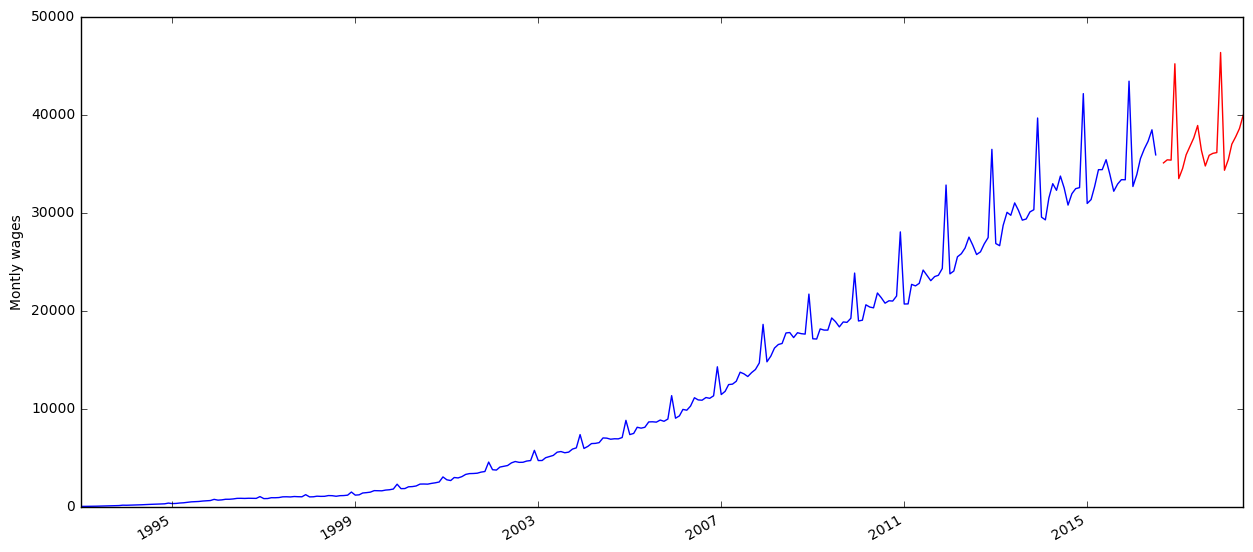

In [123]:
data2 = data[['wage']]
date_list = [datetime.datetime.strptime("2016-07-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns= data2.columns)
data2 = pd.concat([data2, future])
data2['forecast'] = invboxcox(best_model.predict(start=data.shape[0], end=data.shape[0]+24), lmbda)

plt.figure(figsize(15,7))
data2.wage.plot()
data2.forecast.plot(color='r')
plt.ylabel('Montly wages')
pylab.show()